## Step 3: Advanced Feature Engineering

In this notebook, we create advanced features such as lag values, rolling averages, interaction terms, and binned variables to help the model capture time-based and combined effects.


### 1. Load Enriched Dataset
We start by loading the feature-enriched dataset that includes our target variables.


In [1]:
import pandas as pd

merged_data = pd.read_csv('../data/enriched_aqi_weather.csv')
merged_data['date'] = pd.to_datetime(merged_data['date']) #just in case

# preview the data
merged_data.head()

,date,pm10,so2,co,o3,no2,max,tempmax,tempmin,temp,...,windspeed,winddir,cloudcover,uvindex,solarenergy,next_day_aqi,aqi_category,month,dayofweek,is_weekend
0,2016-01-01,72.0,32.0,53.0,51.0,11.0,72.0,32.39,24.00,28.17,...,14.5,312.2,58.2,8,19.6,52.0,Moderate,1,4,False
1,2016-01-02,52.0,32.0,29.0,50.0,12.0,52.0,31.72,24.89,27.17,...,17.7,306.2,68.0,7,15.8,50.0,Good,1,5,True
2,2016-01-03,44.0,33.0,33.0,50.0,18.0,50.0,32.72,25.00,28.39,...,11.1,292.7,56.7,7,15.1,103.0,Unhealthy,1,6,True
3,2016-01-04,61.0,33.0,36.0,103.0,24.0,103.0,31.72,26.00,28.56,...,7.8,306.9,61.8,8,16.5,99.0,Moderate,1,0,False
4,2016-01-05,99.0,33.0,54.0,67.0,22.0,99.0,32.39,25.17,28.56,...,11.4,10.7,59.0,7,18.7,75.0,Moderate,1,1,False


### 2. Create Lag Features

Lag features help capture the effect of past AQI or weather on the next day's AQI.


In [2]:
# 1-day lag features
merged_data['aqi_lag1'] = merged_data['max'].shift(1)
merged_data['tempmax_lag1'] = merged_data['tempmax'].shift(1)
merged_data['humidity_lag1'] = merged_data['humidity'].shift(1)

# 3-day lag AQI for trend modelling
merged_data['aqi_lag3'] = merged_data['max'].shift(3)

# preview the new features
merged_data[['date', 'max', 'aqi_lag1', 'aqi_lag3']].head()


,date,max,aqi_lag1,aqi_lag3
0,2016-01-01,72.0,NaN,NaN
1,2016-01-02,52.0,72.0,NaN
2,2016-01-03,50.0,52.0,NaN
3,2016-01-04,103.0,50.0,72.0
4,2016-01-05,99.0,103.0,52.0


### 3. Create Rolling Averages

Rolling averages show trends over a window of time, like a 3-day or 5-day moving average.


In [3]:
merged_data['rolling_aqi_3'] = merged_data['max'].rolling(window=3).mean()
merged_data['rolling_tempmax_3'] = merged_data['tempmax'].rolling(window=3).mean()

### 4. Create Interaction Features

We multiply related features to capture interactions, like hot & humid days or fast winds with cloudiness.


In [4]:
merged_data['tempmax_x_humidity'] = merged_data['tempmax'] * merged_data['humidity']
merged_data['wind_x_cloud'] = merged_data['windspeed'] * merged_data['cloudcover']

### 5. Create Binned Features

We simplify temperature into categories like 'Cool', 'Warm', and 'Hot' to help decision trees.


In [5]:
def tempmax_category(temp):
    if temp < 25:
        return 'Cool'
    elif 25 <= temp < 30:
        return 'Warm'
    elif 30 <= temp < 34:
        return 'Hot'
    else:
        return 'Very Hot'
    
merged_data['tempmax_category'] = merged_data['tempmax'].apply(tempmax_category)
# preview the value counts
merged_data['tempmax_category'].value_counts()

tempmax_category
Hot         1735
Very Hot     174
Warm         140
Name: count, dtype: int64

### Correlation Heatmap


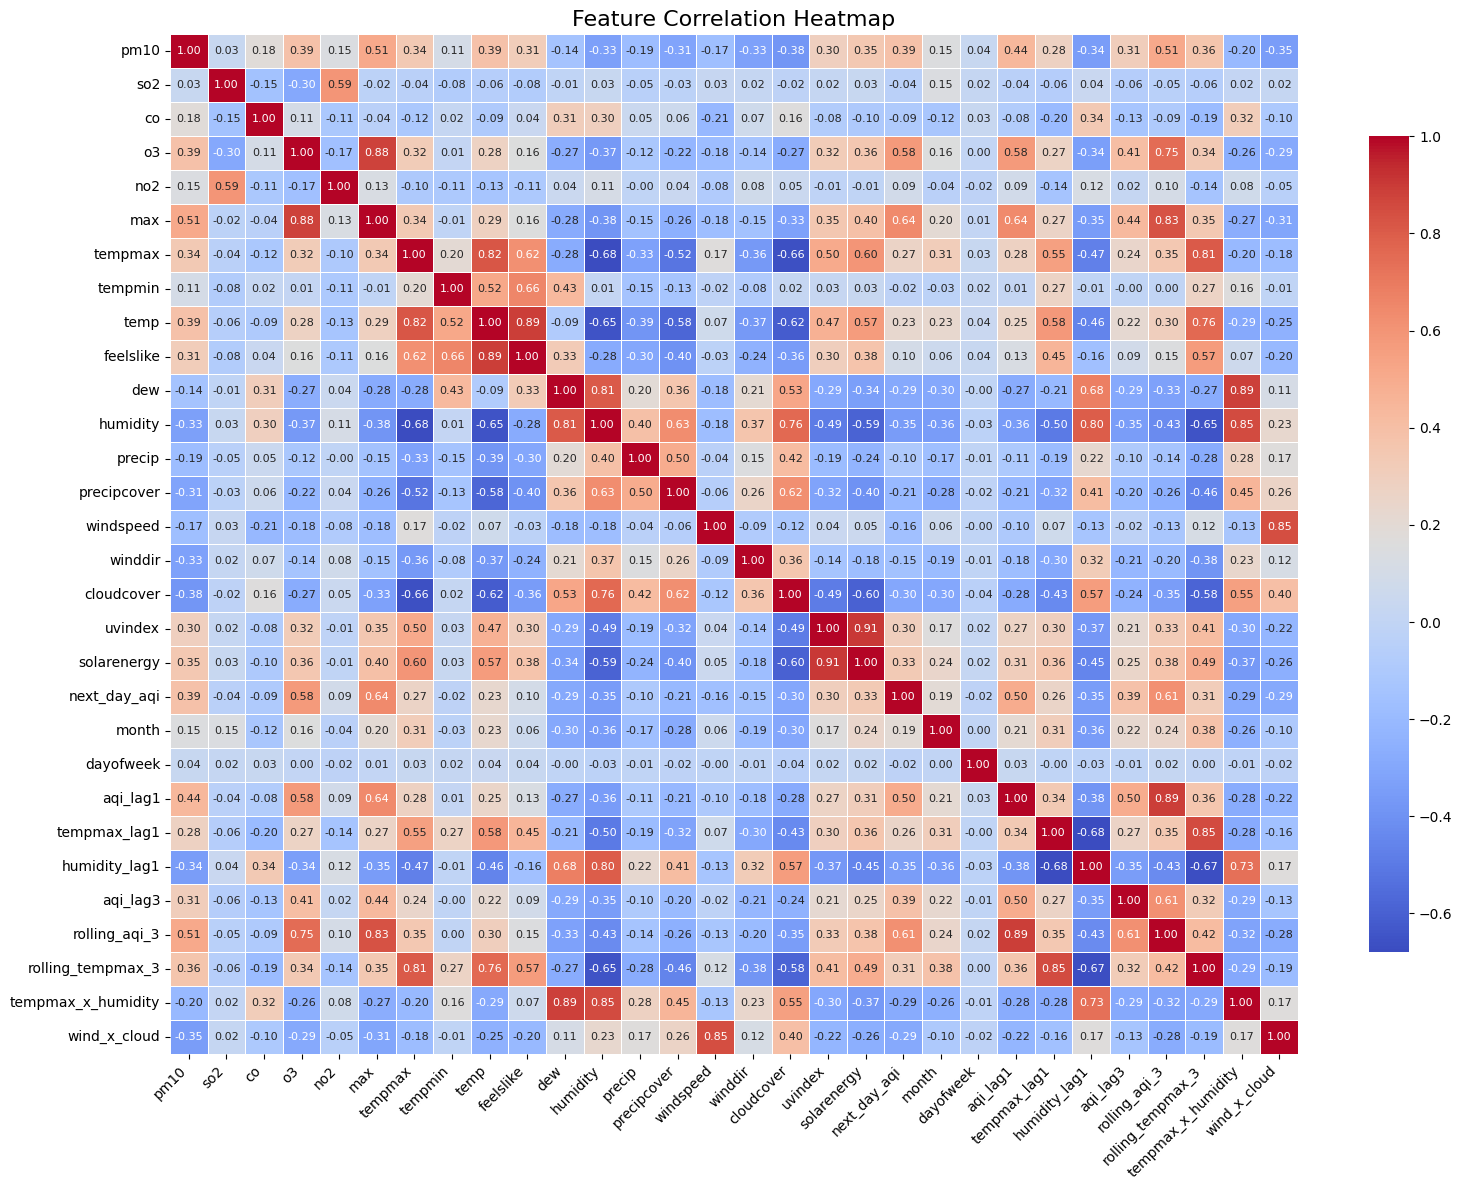

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns
numeric_cols = merged_data.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Plot
plt.figure(figsize=(16, 12))  # bigger figure
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=False,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 8}
)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()


Key observations:
- `max` AQI is strongly correlated with `next_day_aqi` and its lag features (e.g., `aqi_lag1`, `rolling_aqi_3`), which supports their use in prediction.
- `tempmax`, `humidity`, and `windspeed` show moderate correlation with AQI, validating their inclusion in the feature set.
- Some weather features like `cloudcover`, `solarenergy`, and `dew` have lower correlation, but may still contribute useful signals in non-linear models like Random Forest.

This heatmap justifies the selection of features used in model training and highlights multicollinearity that could be considered in future model refinements.


### 6. Save Final Dataset

We save this version with all the features added for model training.


In [7]:
# save to a new CSV file
merged_data.to_csv('../data/final_dataset.csv', index=False)